In [8]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation, LSTM, Masking

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

import re

np.random.seed(42)
tf.random.set_seed(42)

# load data

In [5]:
df1_ori=pd.read_csv('input_data_S3-MON.csv', low_memory = False)

In [6]:
df1_ori

,Unnamed: 0,TimePeriod,Act1,Act2,Act3,Act4,Act5,Act6,Act7,Act8,Act9,Act10,Act11,Act12,id1,final_result
0,0,T0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
1,1,T1,20.0,0.0,5.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
2,2,T2,36.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
3,3,T3,19.0,0.0,0.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
4,4,T4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53405,53405,T5,0.0,29.0,14.0,16.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,[5340.0],[1.0]
53406,53406,T6,0.0,35.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[5340.0],[1.0]
53407,53407,T7,0.0,9.0,9.0,21.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,[5340.0],[1.0]
53408,53408,T8,54.0,92.0,11.0,39.0,0.0,11.0,0.0,4.0,0.0,0.0,0.0,0.0,[5340.0],[1.0]


In [7]:
df1_sorted=df1_ori.sort_values(by=['id1'])
df1_sorted.head(10)

,Unnamed: 0,TimePeriod,Act1,Act2,Act3,Act4,Act5,Act6,Act7,Act8,Act9,Act10,Act11,Act12,id1,final_result
0,0,T0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
1,1,T1,20.0,0.0,5.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
2,2,T2,36.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
3,3,T3,19.0,0.0,0.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
4,4,T4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
5,5,T5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
6,6,T6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
7,7,T7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
8,8,T8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]
9,9,T9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0.0],[0.0]


In [5]:
df = df1_sorted

In [6]:
df['TimePeriod'] = df['TimePeriod'].apply(lambda x: int(x.replace('T', '')))
df['id1'] = df['id1'].apply(lambda x: int(re.sub('\[(\d*)(\.0)\]', '\\1', x)))
df['final_result'] = df['final_result'].apply(lambda x: int(re.sub('\[(\d)(\.0)\]', '\\1', x)))
df.sort_values(by=['id1', 'TimePeriod'], inplace=True)

In [7]:
df1_sorted=df

# prepare dataset for y

In [8]:
df1_sorted

,Unnamed: 0,TimePeriod,Act1,Act2,Act3,Act4,Act5,Act6,Act7,Act8,Act9,Act10,Act11,Act12,id1,final_result
0,0,0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1,20.0,0.0,5.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2,2,36.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,3,3,19.0,0.0,0.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53405,53405,5,0.0,29.0,14.0,16.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,5340,1
53406,53406,6,0.0,35.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5340,1
53407,53407,7,0.0,9.0,9.0,21.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,5340,1
53408,53408,8,54.0,92.0,11.0,39.0,0.0,11.0,0.0,4.0,0.0,0.0,0.0,0.0,5340,1


In [9]:
y = df1_sorted['final_result']
y.shape

(53410,)

# prepare dataset for X

In [10]:
X=df1_sorted.drop(['final_result','id1','Unnamed: 0'], axis=1)
X

,TimePeriod,Act1,Act2,Act3,Act4,Act5,Act6,Act7,Act8,Act9,Act10,Act11,Act12
0,0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,20.0,0.0,5.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,36.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,19.0,0.0,0.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53405,5,0.0,29.0,14.0,16.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
53406,6,0.0,35.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53407,7,0.0,9.0,9.0,21.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0
53408,8,54.0,92.0,11.0,39.0,0.0,11.0,0.0,4.0,0.0,0.0,0.0,0.0


In [11]:
X.shape

(53410, 13)

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [14]:
X = X.reshape(53410,13,1)

# build CNN model

In [15]:
from sklearn.model_selection import KFold
X = np.array(X)
y = np.array(y)
kf = KFold(n_splits=10,shuffle=True, random_state=42)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


KFold(n_splits=10, random_state=42, shuffle=True)
TRAIN: [    0     1     2 ... 53407 53408 53409] TEST: [    4     6    40 ... 53386 53388 53389]
TRAIN: [    0     1     2 ... 53407 53408 53409] TEST: [    7    31    34 ... 53348 53368 53398]
TRAIN: [    0     2     3 ... 53407 53408 53409] TEST: [    1    13    30 ... 53396 53399 53402]
TRAIN: [    1     2     3 ... 53407 53408 53409] TEST: [    0    11    17 ... 53358 53364 53372]
TRAIN: [    0     1     2 ... 53406 53407 53409] TEST: [    8    32    39 ... 53401 53403 53408]
TRAIN: [    0     1     2 ... 53406 53407 53408] TEST: [    3    14    29 ... 53392 53393 53409]
TRAIN: [    0     1     2 ... 53407 53408 53409] TEST: [   18    19    24 ... 53380 53381 53385]
TRAIN: [    0     1     2 ... 53407 53408 53409] TEST: [    5    15    20 ... 53404 53405 53406]
TRAIN: [    0     1     3 ... 53407 53408 53409] TEST: [    2    10    12 ... 53365 53375 53395]
TRAIN: [    0     1     2 ... 53406 53408 53409] TEST: [    9    55    60 ...

In [16]:
cvscores_accuracy = []
cvscores_fscore = []
cvscores_auc = []

for train_index, test_index in kf.split(X):
    cvscores_fscore_temp = 0
    print("\nRunning a new one...")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('\n # of train:{}; # of test:{}; total #:{}'.format(len(X_train), len(X_test), len(X_train)+len(X_test)))
    
    lr=0.001
    epochs = 400

    model = Sequential()
    model.add(Conv1D(filters=128,kernel_size=3, strides=2, input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy','Recall','Precision','AUC'])

    print(model.summary())
    
    history_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128,verbose=0)    
    scores = model.evaluate(X_test, y_test)
    cvscores_fscore_temp = (2*scores[2]*scores[3])/(scores[2]+scores[3])
    print(scores[1])
    print(cvscores_fscore_temp)
    print(scores[4])

    cvscores_accuracy.append(scores[1] * 100)
    cvscores_fscore.append(cvscores_fscore_temp * 100)
    cvscores_auc.append(scores[4] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_accuracy), np.std(cvscores_accuracy)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_fscore), np.std(cvscores_fscore)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_auc), np.std(cvscores_auc)))


Running a new one...

 # of train:48069; # of test:5341; total #:53410
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 128)            512       
                                                                 
 activation (Activation)     (None, 6, 128)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)            

167/167 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7738 - recall: 0.9340 - precision: 0.7818 - auc: 0.7932
0.7738251090049744
0.8511215390342964
0.7932035326957703

Running a new one...

 # of train:48069; # of test:5341; total #:53410
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6, 128)            512       
                                                                 
 activation_6 (Activation)   (None, 6, 128)            0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 3, 128)            0         
                                                 

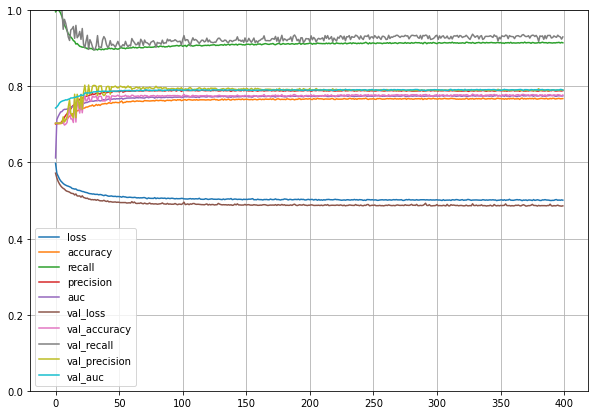

In [17]:
import matplotlib.pyplot as plt

pd.DataFrame(history_model.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

85.79% (+/- 1.07%)
90.03% (+/- 0.77%)
89.18% (+/- 1.13%)
lr=0.001
epochs = 400
    model = Sequential()
    model.add(Conv1D(filters=128,kernel_size=3, strides=2, input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))